# PROGETTO DIGITAL SIGNAL IMAGE MANAGEMENT
### IMAGE RETRIVAL

Cattaneo Andrea, matricola n°815585, a.cattaneo66@campus.unimib.it\
Marinoni Andrea, matricola n°799690, a.marinoni14@campus.unimib.it\
Marzorati Stefano, matricola n°830272, s.marzorati11@campus.unimib.it 

La terza parte del progetto si pone l'obiettivo di cercare pattern/somiglianze all'interno di un dataset di immagini.\
Il dataset utilizzato è costituito da immagini di celebrities e da un'immagine per ogni componente del gruppo che permette di trovare le 10 immagini di celebrità che assomigliano di più ai componenti.

#IMAGE RETRIVAL

##Librerie

In [ ]:
# Keras modules
from tensorflow import keras
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.vgg16 import VGG16
keras.__version__

'2.8.0'

In [ ]:
# KDTree creation and saving
from sklearn.neighbors import KDTree
import joblib

# Data loading
from shutil import copyfile
import zipfile

# Misc
from matplotlib import pyplot as plt
from time import time
import numpy as np
import os

import cv2 as cv
import re

from google.colab.patches import cv2_imshow
import re

## Caricamento Dataset

La macchina virtuale, colab, viene collegata alla repository di Gdrive

In [ ]:
# Link Google Drive account, transfer dataset, and extract files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


La cartella desiderata viene importata ed estratta dal file compresso, in modo da migliorare le performance di caricamento ed averla disponibile durante lo studio. 
Si procede con l'importazione del dataset_famosi contenente immagini di celebrities.

In [ ]:
copyfile('/content/gdrive/MyDrive/DSIM_project/dataset_retrieval/thumbnails_features_deduped_publish.zip',
         'dataset_famosi.zip')

zip = zipfile.ZipFile('dataset_famosi.zip')
zip.extractall()
zip.close()


Si procede con l'importazione del dataset immagini_nostre per poter estrarre le 3 immagini da confrontare

In [ ]:
# Transfer zip dataset to the current virtual machine
copyfile('gdrive/My Drive/DSIM_project/immagini_nostre.zip', 'immagini_nostre.zip')
# Extract files
zip = zipfile.ZipFile('immagini_nostre.zip')
zip.extractall()
zip.close()

##MOBILE NET V2

Si importa il modello preaddestrato MobileNetV2, si basa su una struttura residua invertita in cui l'input e l'output del blocco residuo sono strati di collo di bottiglia sottili opposti ai modelli residui tradizionali che utilizzano rappresentazioni espanse nell'input.  
MobileNetV2 utilizza convoluzioni in profondità per filtrare le caratteristiche nello strato di espansione intermedio.   Inoltre rimuove le non linearità negli strati stretti per mantenere il potere rappresentativo.  
Infine, consente il disaccoppiamento dei domini input/output dall'espressività della trasformazione, il che fornisce un quadro conveniente per ulteriori analisi.

###Preparazione rete:
Viene scaricata la rete base preaddestrata su imagenet, escludendo i layer finali di output, poichè non la mappatura agli output della rete originale.

In [ ]:
net = keras.applications.MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='max')

9420800/9406464 [==============================] - 0s 0us/step


Viene specificato il numero massimo di immagini utilizzabile per ogni celebrità. Questo vincolo è stato scelto in modo da limitare il tempo e le risorse necessarie per la computazione

In [ ]:
maximages = 5

### Crop faccia

Il Crop viene eseguito per rimuovere tutti gli oggetti e le aree indesiderate da un'immagine. Può essere anche utilizzato per evidenziare caratteristiche importanti.   
In questo caso il crop è utilizzato per identificare le facce delle celebrità e confrontarle con le nostre.

In [ ]:
def face_crop(img):
    face_detector = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray)
    for (x,y,w,h) in faces:
        face = img[y:y + h, x:x + w]
        resized_face = cv.resize(face, dsize=(224, 224), interpolation=cv.INTER_CUBIC)
        return resized_face

La funzione `load_data` permette di croppare le facce richiamando la funzione `face_crop` ed estrae le feature tramite una funzione di feature extractor.

In [ ]:
def load_data(feature_extractor):
    base_path = 'thumbnails_features_deduped_publish/'

    paths = []
    features = []
    

    for folder in os.listdir(base_path):
      fi = 0
      for f in sorted(os.listdir(base_path + folder)):
          if f.endswith('.jpg') and fi<maximages:
              cur_path = base_path + folder + '/' + f

              fi += 1
              
              image = cv.imread(cur_path)
              image = face_crop(image)
              if image is not None:
                cur_features = feature_extractor(image)
                paths.append(cur_path)
                features.append(cur_features)

    features = np.array(features)
    return features, paths


Viene specificato il feature extractor usato in questo studio, in particolare viene utilizzata la rete base caricata in precedenza senza i layer finali, ciò permette di estrarre le feature per ogni immagine.

In [ ]:
def neural_features(img):
    x = img
    x = keras.applications.mobilenet_v2.preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    f = net.predict(x)
    return f.flatten()

In [ ]:
X_train, paths = load_data(feature_extractor=neural_features)

In [ ]:
len(paths)

7168

In [ ]:
X_train.shape

(7168, 1280)

###Confronto con nostre immagine 

KDTree è un modello ad albero che partiziona lo spazio per organizzare i punti in un sottospazio k-dimensionale.  
KDTree è un albero di ricerca che in questo studio ci permette di confrontare e trovare le immagini più simili a quella di ogni componente del gruppo.

In [ ]:
tree = KDTree(X_train)

Si estraggono le features dalle 3 immagini dei componenti nello stesso modo utilizzato per le immagini delle celebrities, in modo da poter effettuare un confronto.

In [ ]:
def load_image(path):
  image = cv.imread(path)
  image = face_crop(image)
  if image is not None:
    feature = neural_features(image)
    return np.expand_dims(feature, axis=0)

In [ ]:
query_features_1 = load_image('/content/immagini_nostre/big_mari/IMG_20220704_171833.jpg')
query_features_1.shape

(1, 1280)

In [ ]:
query_features_2 = load_image('/content/immagini_nostre/rimbalzino/IMG_20220704_171632.jpg')
query_features_2.shape

(1, 1280)

In [ ]:
query_features_3 = load_image('/content/immagini_nostre/ste_manzo/IMG_20220704_172116.jpg')
query_features_3.shape

(1, 1280)

Vengono estratti dall'albero i 10 vicini con distanza minore per ogni componente del gruppo.

In [ ]:
dist_1, ind_1 = tree.query(query_features_1, k=10)
dist_2, ind_2 = tree.query(query_features_2, k=10)
dist_3, ind_3 = tree.query(query_features_3, k=10)

In [ ]:
# Position of the most similar element inside our dataset
ind_1
# Distance of the most similar element inside our dataset
dist_1

array([[77.32882646, 79.33514055, 79.92106189, 80.01280689, 80.22771978,
        80.29898585, 80.67105483, 81.3778855 , 81.54311542, 82.06604277]])

In [ ]:

def plot_figure(paths, ind):
  plt.figure(figsize=(20, 10))
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(cv.cvtColor((cv.imread(paths[ind[0][i]])), cv.COLOR_BGR2RGB))
    plt.title(str(i+1) + '. ' + re.findall('\/(.*?)\/', paths[ind[0][i]])[0])
    plt.axis('off')

**bigmari**

Visualizziamo le 10 immagini di star con features simili ad Andrea Marinoni

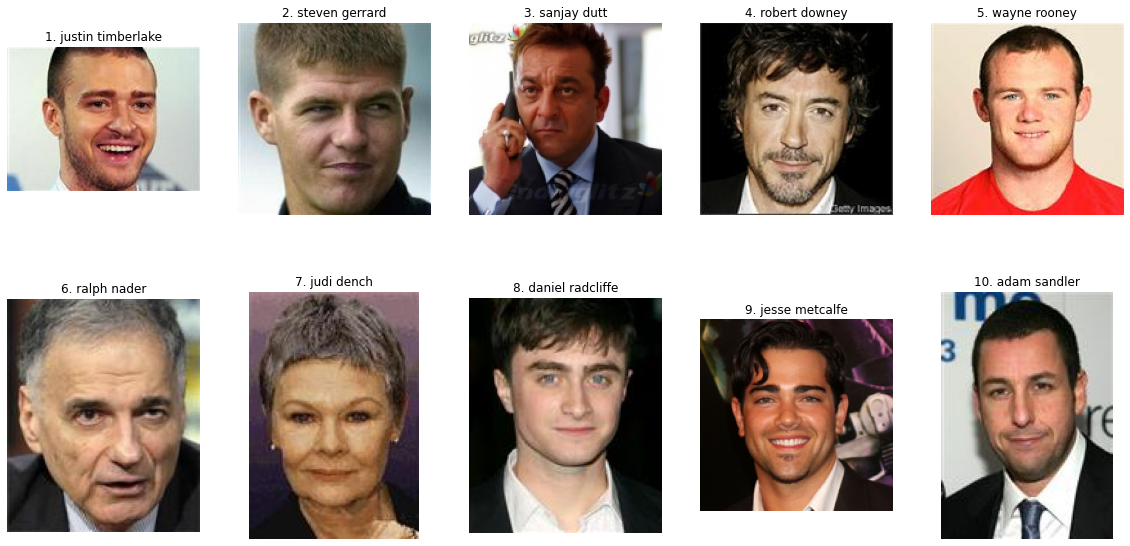

In [ ]:
plot_figure(paths, ind_1)

**rimbalzino**

Visualizziamo le 10 immagini di star con features simili ad Andrea Cattaneo

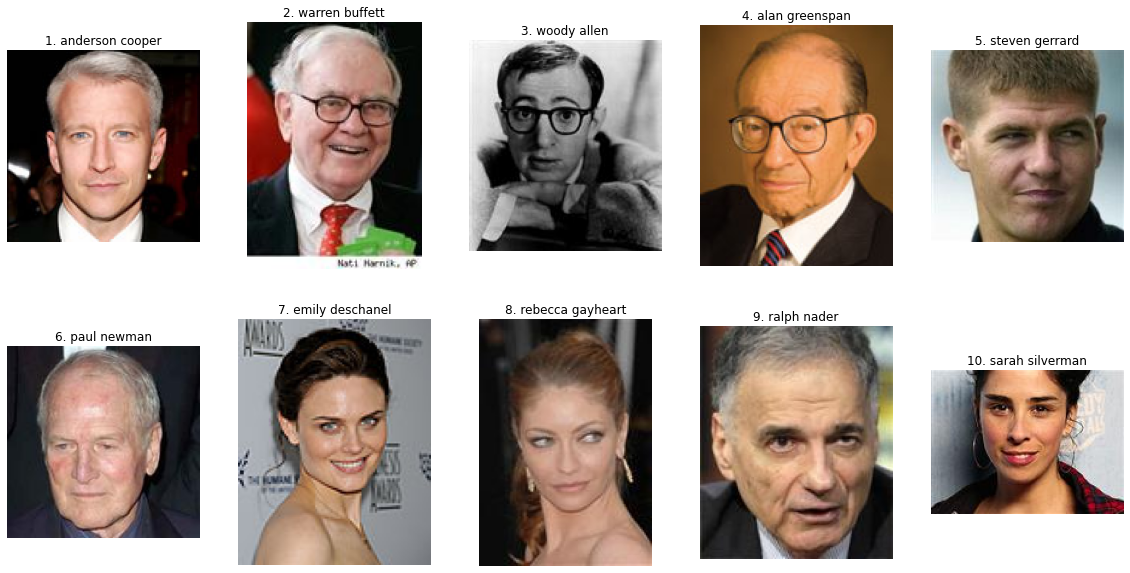

In [ ]:
plot_figure(paths, ind_2)

**stemanzo**

Visualizziamo le 10 immagini di star con features simili a Stefano Marzorati

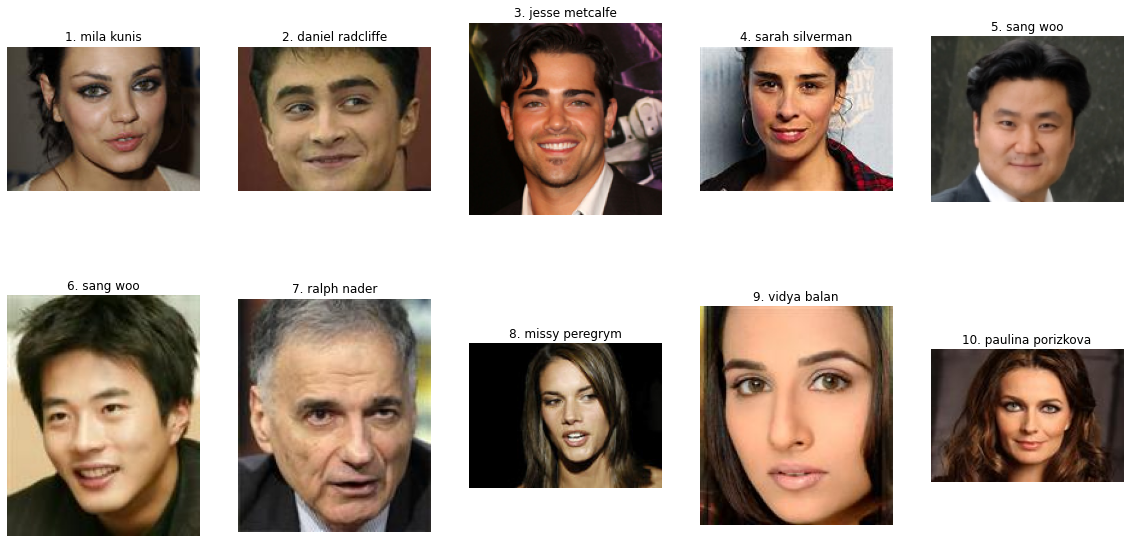

In [ ]:
plot_figure(paths, ind_3)

In [ ]:
joblib.dump(tree, 'mobile_v2_kdtree.joblib')

['mobile_v2_kdtree.joblib']

##VGG16

VGG16 è caratterizzato dall'applicazione di una serie di blocchi convoluzionali con dimensioni del kernel piccole, seguiti da due diversi layer fully connected che mappano a 4096 e infine layer finale che mappa a 1000, la dimensione del problema di classificazione originale. Questi ultimi layer in particolare richiedono un numero molto alto di parametri e anche rispetto al numero di operazioni richieste questa rete risulta essere molto complessa rispetto ad altre.

Il procedimento seguito per questo studio è il medesimo del precedente, cambia però la rete base utilizzata come feature extractor.

In [ ]:
net_vgg16 = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False,)

58900480/58889256 [==============================] - 0s 0us/step


###Image Retrival

In [ ]:
def neural_features_vgg16(img):
    x = img
    x = keras.applications.vgg16.preprocess_input(x) 
    x = np.expand_dims(x, axis=0)
    f = net_vgg16.predict(x)
    return f.flatten()

In [ ]:
t0 = time()
X_train_vgg16, paths_vgg16 = load_data(feature_extractor=neural_features_vgg16)
print("Data loading and feature extraction completed in %0.3f seconds." % (time() - t0))

Data loading and feature extraction completed in 693.505 seconds.


In [ ]:
len(paths_vgg16)

7168

In [ ]:
X_train_vgg16.shape

(7168, 25088)

###Confronto con nostre immagine 

In [ ]:
tree = KDTree(X_train_vgg16)

In [ ]:
def load_image(path, feature_extractor):
  image = cv.imread(path)
  image = face_crop(image)
  if image is not None:
    feature = feature_extractor(image)
    return feature

In [ ]:
query_features_1 = load_image('/content/immagini_nostre/big_mari/IMG_20220704_171833.jpg', neural_features_vgg16)
query_features_1.shape

(25088,)

In [ ]:
query_features_1 = np.expand_dims(query_features_1, axis=0)
query_features_1.shape

(1, 25088)

In [ ]:
query_features_2 = load_image('/content/immagini_nostre/rimbalzino/IMG_20220704_171632.jpg', neural_features_vgg16)
query_features_2.shape

(25088,)

In [ ]:
query_features_2 = np.expand_dims(query_features_2, axis=0)
query_features_2.shape

(1, 25088)

In [ ]:
query_features_3 = load_image('/content/immagini_nostre/ste_manzo/IMG_20220704_172116.jpg',neural_features_vgg16)
query_features_3.shape

(25088,)

In [ ]:
query_features_3 = np.expand_dims(query_features_3, axis=0)
query_features_3.shape

(1, 25088)

In [ ]:
dist_1, ind_1 = tree.query(query_features_1, k=10)
dist_2, ind_2 = tree.query(query_features_2, k=10)
dist_3, ind_3 = tree.query(query_features_3, k=10)

**bigmari**

Visualizziamo le 10 immagini di star con features simili a Andrea Marinoni

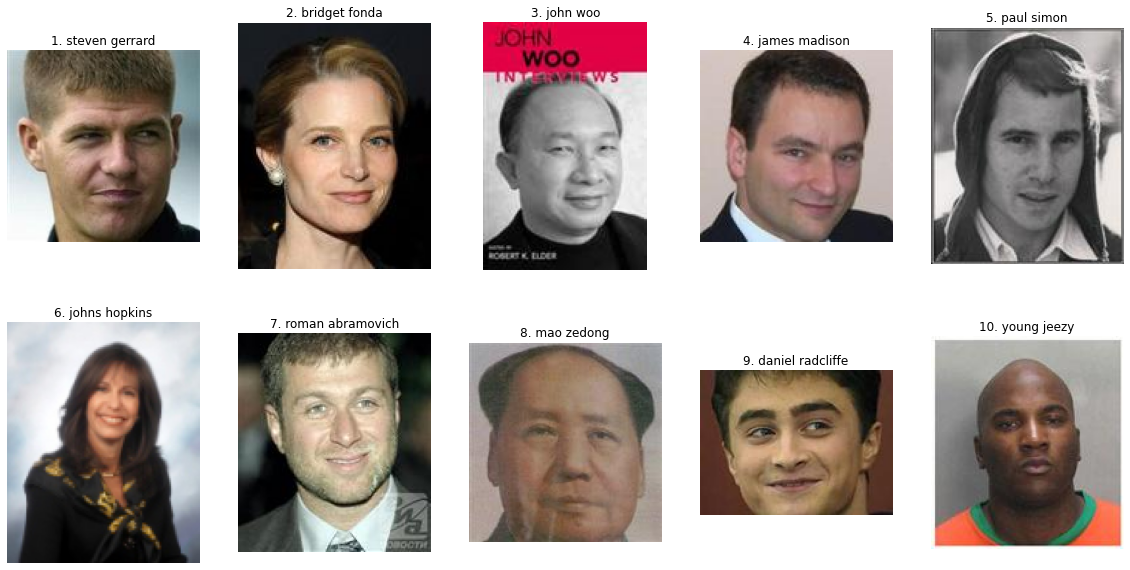

In [ ]:

plt.figure(figsize=(20, 10))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(cv.cvtColor((cv.imread(paths[ind_1[0][i]])), cv.COLOR_BGR2RGB))
  plt.title(str(i+1) + '. ' + re.findall('\/(.*?)\/', paths[ind_1[0][i]])[0])
  plt.axis('off')

**rimbalzino**

Visualizziamo le 10 immagini di star con features simili a Andrea Cattaneo

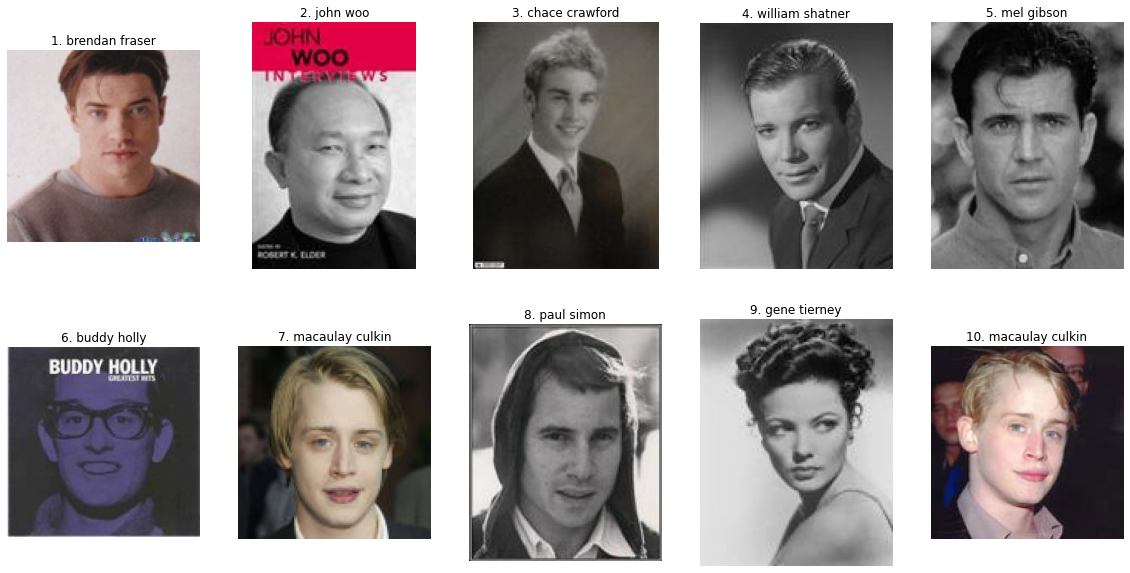

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(cv.cvtColor((cv.imread(paths[ind_2[0][i]])), cv.COLOR_BGR2RGB))
  plt.title(str(i+1) + '. ' + re.findall('\/(.*?)\/', paths[ind_2[0][i]])[0])
  plt.axis('off')

**stemanzo**

Visualizziamo le 10 immagini di star con features simili a Stefano Marzorati

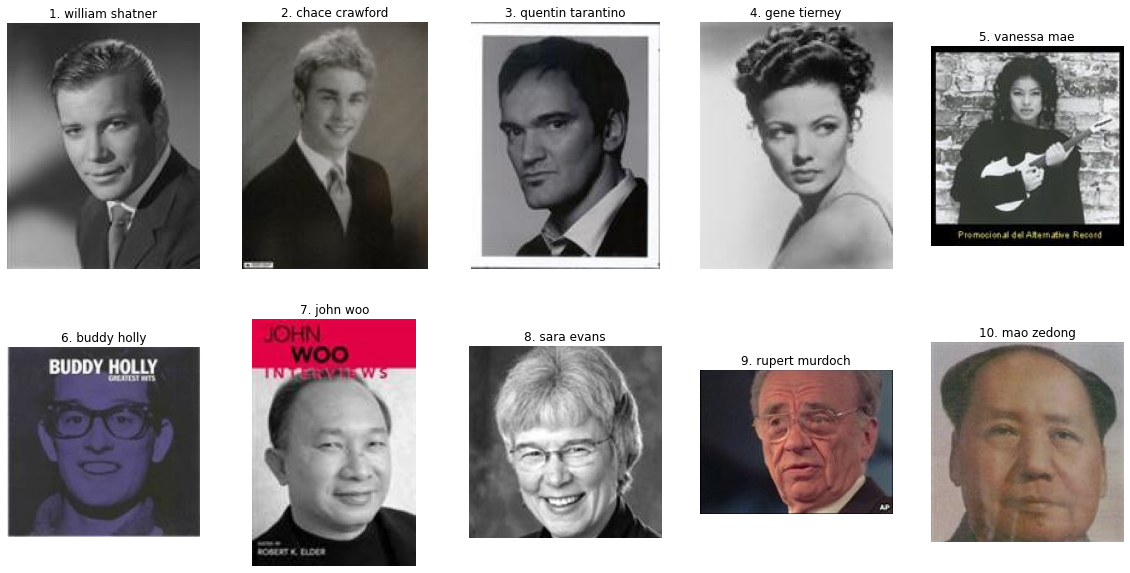

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(cv.cvtColor((cv.imread(paths[ind_3[0][i]])), cv.COLOR_BGR2RGB))
  plt.title(str(i+1) + '. ' + re.findall('\/(.*?)\/', paths[ind_3[0][i]])[0])
  plt.axis('off')

In [ ]:
# Saving the search tree
joblib.dump(tree, 'cat_kdtree.joblib')

['cat_kdtree.joblib']